# Packeges

In [45]:
import pandas as pd
import numpy as np

#from tensorflow.keras.preprocessing import text, sequence
#from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


# To handle imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# for encoding categorial vars
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

# engineering numerical vars
from sklearn.compose  import ColumnTransformer
from sklearn.preprocessing import PowerTransformer,  MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
## basis expension
from sklearn.preprocessing import PolynomialFeatures , SplineTransformer



# to help understand the results
import matplotlib.pyplot as plt

# model selction
from sklearn.model_selection import GridSearchCV

# dealing with imalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# models used for feature selection
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt




In [4]:
food_train = pd.read_csv("/home/dovikde/Documents/Studies/Ds_applications/Final_ProjectTuchdov/data/food_train.csv")
nutrients = pd.read_csv("/home/dovikde/Documents/Studies/Ds_applications/Final_ProjectTuchdov/data/nutrients.csv")
food_nutrients = pd.read_csv("/home/dovikde/Documents/Studies/Ds_applications/Final_ProjectTuchdov/data/food_nutrients.csv")
food_test = pd.read_csv("/home/dovikde/Documents/Studies/Ds_applications/Final_ProjectTuchdov/data/food_test.csv")

In [5]:
n = len(food_train)
n

31751

In [6]:
# return all the numbers in nutrient id
# nut_wide = nutrients.pivot(index="idx", columns="nutrient_id", values="amount")
nut_ids = ['idx']
for id in nutrients.nutrient_id:
    nut_ids.append(id)

nut_data = pd.DataFrame(columns = nut_ids)
nut_data

,idx,1002,1003,1004,1005,1007,1008,1009,1010,1011,...,2021,2022,2023,2024,2025,2026,2028,2029,2032,2033


#start_time = time.time()
appended_data = [nut_data]
for value in range(n):
    # for every snack in the training sample get it's nutritional values
    indx = food_train['idx'][value]
    df2 = food_nutrients.query("idx == @indx").loc[:, 'nutrient_id':'amount'].set_index("nutrient_id").T
    df2['idx']= indx
    appended_data.append(df2)
    print(value)

appended_data = pd.concat(appended_data, axis=0)

#end_time = time.time()
#print('Execution time = %.6f seconds' % (end_time-start_time))

In [7]:
#appended_data

In [8]:
#appended_data.to_csv('all_nuts.csv')

In [9]:
appended_data2 = pd.read_csv('/home/dovikde/Documents/Studies/Ds_applications/Final_ProjectTuchdov/data/all_nuts.csv')

In [10]:
# fill zero where there isn't any nutritional data
appended_data2 = appended_data2.fillna(0.0).reset_index(drop = True)


In [11]:
main = food_train.merge(appended_data2, on='idx', how='left')
#main

In [12]:
main.loc[:, "category"] = main.category.astype('category')
main.loc[:, "serving_size_unit"] = main.serving_size_unit.astype('category')


In [13]:
# make a list of unique brands in each category
# leave the brands that  only belong to one category
# list of categorys
cat_list = food_train.category.unique()
cat_list

array(['chocolate', 'cookies_biscuits', 'cakes_cupcakes_snack_cakes',
       'candy', 'chips_pretzels_snacks',
       'popcorn_peanuts_seeds_related_snacks'], dtype=object)

In [14]:
# get all the brands in each category
cat_brand_list = []
for cat in cat_list:
    brand_list = food_train.query('category == @cat').brand.unique()
    cat_brand_list.append(brand_list)


In [15]:
# get all the brands in other categories
other_brand_list = []
for cat in cat_list:
    brand_list = food_train.query('category != @cat').brand.unique()
    other_brand_list.append(brand_list)


In [16]:
# brands that only belong to one category
only_cat = []
for i in range(len(cat_brand_list)):
    mask = np.isin(cat_brand_list[i], other_brand_list[i], invert= True)
    unique_category_brands = cat_brand_list[i][mask]
    only_cat.append(unique_category_brands)
    
#main = main.assign(brand = ['chocolate brand' if a > 0 else 'neg' for a in df['a']])

In [17]:
main = main.assign(brand = ['chocolate_brand' if item in only_cat[0] else item for item in main['brand']])
main = main.assign(brand = ['cookies_biscuits_brand' if item in only_cat[1] else item for item in main['brand']])
main = main.assign(brand = ['cakes_cupcakes_snack_cakes_brand' if item in only_cat[2] else item for item in main['brand']])
main = main.assign(brand = ['candy_brand' if item in only_cat[3] else item for item in main['brand']])
main = main.assign(brand = ['chips_pretzels_snacks_brand' if item in only_cat[4] else item for item in main['brand']])
main = main.assign(brand = ['popcorn_peanuts_seeds_related_snacks_brand' if item in only_cat[5] else item for item in main['brand']])

In [18]:
main.head(5)

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,Unnamed: 0,1002,...,2021,2022,2023,2024,2025,2026,2028,2029,2032,2033
0,1,chocolate_brand,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,1 onz,chocolate,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour (flour, n...",38.0,g,1 cookie,cookies_biscuits,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour (flour, n...",30.0,g,2 cookies,cookies_biscuits,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil (palm kernel, partially h...",40.0,g,5 pieces,cookies_biscuits,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,"ferrero u.s.a., incorporated","ferrero collection, fine assorted confections","semisweet chocolate (sugar, cocoa mass, cocoa ...",40.0,g,4 pieces,chocolate,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# let's see the difference
print('num of original brands', len(food_train.brand.unique()))
print('num of engineered brands',len(main.brand.unique()))

num of original brands 4783
num of engineered brands 971


In [20]:
main2= main.copy()
main2.loc[:, "servings"] = main2.loc[:, "household_serving_fulltext"].str.strip().str.replace('[^a-zA-Z ]', "").str.replace('about', "").str.replace('per container', "").str.strip()
main2.insert(7,"servings", main2.pop('servings'))

/tmp/ipykernel_4752/2093770968.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  main2.loc[:, "servings"] = main2.loc[:, "household_serving_fulltext"].str.strip().str.replace('[^a-zA-Z ]', "").str.replace('about', "").str.replace('per container', "").str.strip()


In [21]:
# make a list of unique brands in each category
# leave the brands that  only belong to one category
# list of categorys
cat_list = food_train.category.unique()
cat_list
# get all the brands in each category
serv_brand_list = []
for cat in cat_list:
    brand_list = main2.query('category == @cat').servings.unique()
    serv_brand_list.append(brand_list)

# get all the brands in other categories
other_serv_list = []
for cat in cat_list:
    brand_list = main2.query('category != @cat').servings.unique()
    other_serv_list.append(brand_list)

# brands that only belong to one category
only_serv = []
for i in range(len(serv_brand_list)):
    mask = np.isin(serv_brand_list[i], other_serv_list[i], invert= True)
    unique_category_servings = serv_brand_list[i][mask]
    only_serv.append(unique_category_servings)
    
#main = main.assign(brand = ['chocolate brand' if a > 0 else 'neg' for a in df['a']])
main2 = main2.assign(servings = ['chocolate_servings' if item in only_serv[0] else item for item in main2['servings']])
main2 = main2.assign(servings = ['cookies_biscuits_servings' if item in only_serv[1] else item for item in main2['servings']])
main2 = main2.assign(servings = ['cakes_cupcakes_snack_cakes_servings' if item in only_serv[2] else item for item in main2['servings']])
main2 = main2.assign(servings = ['candy_servings' if item in only_serv[3] else item for item in main2['servings']])
main2 = main2.assign(servings = ['chips_pretzels_snacks_servings' if item in only_serv[4] else item for item in main2['servings']])
main2 = main2.assign(servings = ['popcorn_peanuts_seeds_related_snacks_servings' if item in only_serv[5] else item for item in main2['servings']])# doing the same thing I did with brands to servings


In [22]:
len(main2.servings.unique()) # 146

135

In [23]:
# let's try to stemm
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english") #define stemming dict


In [24]:
main3 = main2.copy()
main3.loc[:,"servings"] = main3.loc[:,"servings"].astype(str)

In [25]:
main3.loc[:,"servings"]= main3.loc[:,"servings"].apply(stemmer.stem)
#main3.loc[:"servings"].head(10).applymap(stemmer.stem)
#main3.loc[: "servings"].info
# let's see the difference
print('num of original servings', len(food_train.household_serving_fulltext.unique()))
print('num of engineered servings',len(main3.servings.unique()))

num of original servings 2207
num of engineered servings 115


In [26]:
main3.query("serving_size_unit == 'ml'").shape


(8, 245)

There are only 8 observations that have ml in them, i will choosr to drop themb

In [27]:
main4 = main3.copy()
# main4 = main3.query("serving_size_unit != 'ml'")
main4 = main4.drop(['household_serving_fulltext',"serving_size_unit","ingredients","description"], axis = 1)
main4.loc[:,'brand'] = main4.loc[:,'brand'].astype('category')

In [28]:
main4 = main3.copy()
# main4 = main3.query("serving_size_unit != 'ml'")
main4 = main4.drop(['household_serving_fulltext',"serving_size_unit","ingredients","description"], axis = 1)
main4.loc[:,'brand'] = main4.loc[:,'brand'].astype('category')

In [29]:
# i will also drop the discripttion and ingredients
main4.brand.count()
brands_df = main4.groupby(['brand']).size().sort_values(ascending = False)
brands_df

brand
candy_brand                                   2081
popcorn_peanuts_seeds_related_snacks_brand    1979
cookies_biscuits_brand                        1831
cakes_cupcakes_snack_cakes_brand              1156
chips_pretzels_snacks_brand                   1132
                                              ... 
pure creativity llc                              2
thompson's                                       2
in-between sportwear, inc.                       2
protes                                           2
english bay batter inc.                          2
Length: 971, dtype: int64

Now we will compare between ways of encoding brand and servings

In [30]:
from sklearn import preprocessing as prep
lb = prep.LabelEncoder()
lable = main4.category
lable = lb.fit_transform(lable)
lable = pd.Series(lable)

In [33]:
unique_brand_list = ['chocolate_brand','cookies_biscuits_brand','candy_brand','chips_pretzels_snacks_brand','popcorn_peanuts_seeds_related_snacks_brand', 'cakes_cupcakes_snack_cakes_brand']
unique_serv_list = ['chocolate_serv' ,'cookies_biscuits_serv','candy_serv','chips_pretzels_snacks_serv','popcorn_peanuts_seeds_related_snacks_serv', 'cakes_cupcakes_snack_cakes_serv']

In [67]:
main4.to_csv("main4.csv")

In [68]:

rf = RandomForestClassifier(max_depth=4, random_state=0, criterion= "entropy")
#clf.fit(X, y)


In [70]:

skf7 = StratifiedKFold(n_splits=7)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Splitting The Data

I'll split the date into 5 parts to handle: class_imbalance, feture engineering, feature selection, model selection, and tuning

In [68]:
X_main , X_class_imb, y_main ,y_class_imb = train_test_split(main4, lable,
 stratify = lable ,
 random_state= 5,
 test_size= round(n/5 + 1))


In [69]:
print(X_main.shape)
print(y_main.shape)

(25400, 241)
(25400,)


In [70]:
X_temp , X_var_selection, y_temp , y_var_selection = train_test_split(X_main, y_main,
 stratify = y_main ,
 random_state= 5,
 test_size= round(n/5 - 1))


In [71]:
X_temp2 , X_fteng, y_temp2 , y_fteng = train_test_split(X_temp, y_temp,
 stratify = y_temp ,
 random_state= 5,
 test_size= round(n/5 - 1))


In [72]:
X_mod_slct , X_mod_tune, y_mod_slct , y_mod_tune = train_test_split(X_temp2, y_temp2,
 stratify = y_temp2 ,
 random_state= 5,
 test_size= 0.5)


In [73]:
print(X_fteng.shape)
print(y_fteng.shape)
print(X_var_selection.shape)
print(y_var_selection.shape)
print(X_class_imb.shape)
print(y_class_imb.shape)
print(X_mod_tune.shape)
print(y_mod_tune.shape)
print(X_mod_slct.shape)
print(y_mod_slct.shape)

(6349, 241)
(6349,)
(6349, 241)
(6349,)
(6351, 241)
(6351,)
(6351, 241)
(6351,)
(6351, 241)
(6351,)


# feature enginnering

In [74]:

rf = RandomForestClassifier(max_depth=4, random_state=0, criterion= "entropy")
#clf.fit(X, y)


In [75]:

skf7 = StratifiedKFold(n_splits=7)
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=1)

## handlng categorial data, feature hashing , One hot encoding

In [37]:
import category_encoders as ce
encoder30=ce.HashingEncoder(cols='brand',n_components=30)
encoder15=ce.HashingEncoder(cols='servings',n_components=15)


In [ ]:

hashed_brand = encoder30.fit_transform(X_fteng.brand)
hashed_serv =  encoder15.fit_transform(X_fteng.servings)

In [77]:
hashed_brand = encoder30.fit_transform(X_fteng.brand)
hashed_serv =  encoder15.fit_transform(X_fteng.servings)
hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')
hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')
X_fteng2 = pd.concat([X_fteng,hashed_brand], axis = 1)
X_fteng2 = pd.concat([X_fteng2,hashed_serv], axis = 1)

In [78]:
# adding the hashes
main5_hsh = main4.copy()
main5_hsh = main5_hsh.drop(['brand',"servings","category","Unnamed: 0", "idx"], axis = 1)
X_fteng2 = pd.concat([X_fteng,hashed_brand], axis = 1)
X_fteng2 = pd.concat([X_fteng2,hashed_serv], axis = 1)
X_fteng2 =  X_fteng2.drop(['brand',"servings" ,"category","Unnamed: 0", "idx"], axis = 1)

In [79]:
scores = cross_val_score(rf, X_fteng2, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.7853205229169947


## one hot encoding + other

In [92]:
unique_brand_list = ['chocolate_brand','cookies_biscuits_brand','candy_brand','chips_pretzels_snacks_brand','popcorn_peanuts_seeds_related_snacks_brand', 'cakes_cupcakes_snack_cakes_brand']
unique_serv_list = ['chocolate_serv' ,'cookies_biscuits_serv','candy_serv','chips_pretzels_snacks_serv','popcorn_peanuts_seeds_related_snacks_serv', 'cakes_cupcakes_snack_cakes_serv']

In [93]:
main5_ohe = main4.copy()
X_fteng2 = X_fteng.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in X_fteng['brand']],
                     servings = ['other_serving' if item not in unique_serv_list else item for item in X_fteng['servings']])
#main5 = main5.drop(['brand',"servings","category"], axis = 1)


In [94]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer

X_fteng2 = X_fteng.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in X_fteng['brand']],
                     servings = ['other_serving' if item not in unique_serv_list else item for item in X_fteng['servings']])                     

enc = OneHotEncoder()


oh_brand = enc.fit_transform(X_fteng2[['brand']]).toarray()
#transformed_df = pd.DataFrame(X_trans, columns=X_trans.getcol)
oh_brand = pd.DataFrame(oh_brand).add_prefix('brand_')
oh_serv = enc.fit_transform(X_fteng2[['servings']]).toarray()
#transformed_df = pd.DataFrame(X_trans, columns=X_trans.getcol)
oh_serv = pd.DataFrame(oh_serv).add_prefix('serving_')


In [95]:
print(oh_brand.shape)
print(oh_serv.shape)

(6349, 7)
(6349, 7)


In [96]:
# adding same index to prevent NAN's
oh_brand.index = X_fteng2.index
oh_serv.index = X_fteng2.index
X_fteng3 = pd.concat([X_fteng2,oh_brand], axis = 1)
X_fteng3 = pd.concat([X_fteng3,oh_serv], axis = 1)
X_fteng3 = X_fteng3.drop(['brand',"servings","category", "Unnamed: 0",'idx'], axis = 1)

In [97]:
X_fteng3.tail()

,serving_size,1002,1003,1004,1005,1007,1008,1009,1010,1011,...,brand_4,brand_5,brand_6,serving_0,serving_1,serving_2,serving_3,serving_4,serving_5,serving_6
26291,43.0,0.0,6.98,27.91,65.12,0.0,535.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11308,30.0,0.0,10.00,30.00,50.00,0.0,540.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27949,40.0,0.0,5.00,0.00,75.00,0.0,325.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3887,28.0,0.0,7.14,35.71,50.00,0.0,571.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16140,28.0,0.0,14.29,100.00,53.57,0.0,1107.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [98]:
scores = cross_val_score(rf, X_fteng3, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.7839817294062056


Conclusion: I will use feature hasing to handle the categorial data

### Hanling with the numerical data

In [99]:
main4.describe()

,idx,serving_size,Unnamed: 0,1002,1003,1004,1005,1007,1008,1009,...,2021,2022,2023,2024,2025,2026,2028,2029,2032,2033
count,31751.000000,31751.000000,31751.000000,31751.0,31751.000000,31751.000000,31751.000000,31751.0,31751.000000,31751.000000,...,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0
mean,17633.624201,37.640052,15875.000000,0.0,6.969363,22.696969,59.658349,0.0,460.058455,0.001485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,10176.708489,20.942359,9165.868535,0.0,6.326502,16.334593,20.385734,0.0,99.050340,0.264552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.225000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,8840.500000,28.000000,7937.500000,0.0,3.330000,10.940000,50.000000,0.0,391.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,17615.000000,30.000000,15875.000000,0.0,5.260000,21.430000,60.710000,0.0,464.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,26458.500000,40.000000,23812.500000,0.0,8.000000,32.140000,72.500000,0.0,533.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,35276.000000,480.000000,31750.000000,0.0,100.000000,100.000000,100.000000,0.0,2157.000000,47.140000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:

vt = VarianceThreshold(0.01)
transformed = vt.fit_transform(X_fteng3)
_ = vt.fit(X_fteng3)
mask = vt.get_support()
Xfeng_rdc = X_fteng3.loc[:, mask]

In [101]:
scores = cross_val_score(rf, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.8211529374704679


 trying to perform yeo-johnson (all values are non-negetive but there are zeros) on the data' it's not neccesary for random forest but it can improe performance


In [102]:
#Xfeng_rdc.iloc[ :,:44].astype('float64')
#Xfeng_rdc.iloc[ :,44:].astype('bool')
#main.loc[:, "serving_size_unit"] = main.serving_size_unit.astype('category')
#dfd = Xfeng_rdc.copy()
#Xfeng_rdc.select_dtypes(include=['float64'])
#Xfeng_rdc.select_dtypes(include=[ 'bool'])

In [103]:
# determine categorical and numerical features
Xfeng_rdc.iloc[ :,:44] = Xfeng_rdc.iloc[ :,:44].astype('float64')
Xfeng_rdc.iloc[ :,44:] = Xfeng_rdc.iloc[ :,44:].astype('bool')
#main.loc[:, "serving_size_unit"] = main.serving_size_unit.astype('category')
#dfd = Xfeng_rdc.copy()

numerical_ix = Xfeng_rdc.select_dtypes(include=['float64']).columns
categorical_ix = Xfeng_rdc.select_dtypes(include=[ 'bool']).columns


/tmp/ipykernel_13035/2826948854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xfeng_rdc.iloc[ :,:44] = Xfeng_rdc.iloc[ :,:44].astype('float64')
/tmp/ipykernel_13035/2826948854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xfeng_rdc.iloc[ :,44:] = Xfeng_rdc.iloc[ :,44:].astype('bool')


In [104]:
t = [('scl', StandardScaler(with_std= False), Xfeng_rdc.iloc[ :,:1].columns) ,('num', PowerTransformer(method='box-cox', standardize=True,), Xfeng_rdc.iloc[ :,:1].columns)]
col_transform = ColumnTransformer(transformers=t)

In [105]:
t = [ ('scale', MinMaxScaler(),numerical_ix) ,('num', PowerTransformer(method='yeo-johnson', standardize=True,), Xfeng_rdc.iloc[ :,:5].columns)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('prep',col_transform), ('m', rf)])
# evaluate the pipeline using cross validation and calculate accuracy
scores = cross_val_score(pipeline, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.7987084580248859


Peformance loss

In [106]:

t = [ ('scale', StandardScaler(),numerical_ix) ,('num', PowerTransformer(method='yeo-johnson', standardize=True,), Xfeng_rdc.iloc[ :,:5].columns)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('prep',col_transform), ('m', rf)])
# evaluate the pipeline using cross validation and calculate accuracy
scores = cross_val_score(pipeline, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.7987084580248859


same perfoemance

In [107]:

t = [ ('spline', SplineTransformer(degree=2, n_knots=3),Xfeng_rdc.iloc[ :,5:46].columns) ,('num', PowerTransformer(method='yeo-johnson', standardize=True,), Xfeng_rdc.iloc[ :,:5].columns)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('prep',col_transform), ('m', rf)])

# evaluate the pipeline using cross validation and calculate accuracy
scores = cross_val_score(pipeline, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.806150574893684


In [108]:
t = [ ('poly', PolynomialFeatures(2),Xfeng_rdc.iloc[ :,0:5].columns) ]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('prep',col_transform), ('m', rf)])

# evaluate the pipeline using cross validation and calculate accuracy
scores = cross_val_score(pipeline, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.7710269333753346


In [109]:

t = [ ('min_max_scale', MinMaxScaler(),Xfeng_rdc.iloc[ :,0:44].columns) ]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('prep',col_transform), ('m', rf)])
# evaluate the pipeline using cross validation and calculate accuracy
scores = cross_val_score(pipeline, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.8211923137501971


In [110]:

t = [ ('scale', StandardScaler(),Xfeng_rdc.iloc[ :,0:44].columns) ]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('prep',col_transform), ('m', rf)])
# evaluate the pipeline using cross validation and calculate accuracy
scores = cross_val_score(pipeline, Xfeng_rdc, y_fteng, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.8211529374704679


Conclusion: I will do min max transformation on the numercial variables and remove the zero variance predictors

In [111]:
X_class_imb2 = X_class_imb.copy()
X_class_imb2 = X_class_imb2.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in X_class_imb2['brand']],
                     servings = ['other_serving' if item not in unique_serv_list else item for item in X_class_imb2['servings']])

hashed_brand = encoder30.fit_transform(X_class_imb2[['brand']])
hashed_serv =  encoder15.fit_transform(X_class_imb2[['servings']])
#oh_brand = enc.fit_transform(X_fteng2[['brand']]).toarray()
hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')
hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')

# adding same index to prevent NAN's
hashed_serv.index = X_class_imb2.index
hashed_brand.index = X_class_imb2.index
X_class_imb3 = pd.concat([X_class_imb2,hashed_serv], axis = 1)
X_class_imb3 = pd.concat([X_class_imb3,hashed_brand], axis = 1)
X_class_imb3 = X_class_imb3.drop(['brand',"servings","category", "Unnamed: 0",'idx'], axis = 1)


cl= X_class_imb3.columns.get_loc('2033') + 1
X_class_imb3.iloc[ :,:cl] = X_class_imb3.iloc[ :,:cl].astype('float64')
X_class_imb3.iloc[ :,cl:] = X_class_imb3.iloc[ :,cl:].astype('bool')

# determine categorical and numerical features


# droping the zero var columns 
vt = VarianceThreshold()
transformed = vt.fit_transform(X_class_imb3)
_ = vt.fit(X_class_imb3)
mask = vt.get_support()
X_class_imb3 = X_class_imb3.loc[:, mask]

# determine categorical and numerical features that's left
numerical_ix = X_class_imb3.select_dtypes(include=['float64']).columns
categorical_ix = X_class_imb3.select_dtypes(include=[ 'bool']).columns

# transforming with min max
t = [ ('scale', MinMaxScaler(),numerical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')
X_trans = ct.fit_transform(X_class_imb3)  
X_class_imb4 = pd.DataFrame(X_trans, index=X_class_imb3.index, columns=X_class_imb3.columns)


# handling class imbalance

we will comapre between 2 methods. class_weights and SMOTE with down sample

### Class weights - Cost sensitive learning 

In [112]:

rf_cs = RandomForestClassifier(max_depth=4, random_state=0, criterion= "entropy", class_weight = 'balanced' )
#clf.fit(X, y)

With Cost Sensitive learning

In [113]:
scores = cross_val_score(rf_cs, X_class_imb4, y_class_imb, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.7890085798658503


Without

In [114]:
scores = cross_val_score(rf, X_class_imb4, y_class_imb, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.8166433126587627


### SMOTE and undersampling

In [115]:


# define pipeline
over = SMOTE(sampling_strategy='all')
under = RandomUnderSampler(sampling_strategy='all')
steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X_class_imb4, y_class_imb)

In [116]:


#cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=1)
scores = cross_val_score(rf, X_smote, y_smote, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.8200289466024129


Conclusion We wll use Smote and Undersampling

# Feature selection


In [117]:
X_var_selection2 = X_var_selection.copy()
X_var_selection2 = X_var_selection2.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in X_var_selection2['brand']],
                     servings = ['other_serving' if item not in unique_serv_list else item for item in X_var_selection2['servings']])
hashed_brand = encoder30.fit_transform(X_var_selection2.brand)
hashed_serv =  encoder15.fit_transform(X_var_selection2.servings)

hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')
hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')

# adding same index to prevent NAN's
hashed_serv.index = X_var_selection2.index
hashed_serv.index = X_var_selection2.index
X_var_selection3 = pd.concat([X_var_selection2,hashed_brand], axis = 1)
X_var_selection3 = pd.concat([X_var_selection3,hashed_serv], axis = 1)
X_var_selection3 = X_var_selection3.drop(['brand',"servings","category", "Unnamed: 0",'idx'], axis = 1)

cl = X_var_selection3.columns.get_loc('2033') + 1
X_var_selection3.iloc[ :,:cl] = X_var_selection3.iloc[ :,:cl].astype('float64')
X_var_selection3.iloc[ :,cl:] = X_var_selection3.iloc[ :,cl:].astype('bool')

# droping the zero var columns 
vt = VarianceThreshold()
_ = vt.fit(X_var_selection3)
mask = vt.get_support()
X_var_selection4 = X_var_selection3.loc[:, mask]

# determine categorical and numerical features that's left
numerical_ix = X_var_selection4.select_dtypes(include=['float64']).columns
categorical_ix = X_var_selection4.select_dtypes(include=[ 'bool']).columns

# transforming with min max
t = [ ('scale', MinMaxScaler(),numerical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')
X_trans = ct.fit_transform(X_var_selection4)  
X_var_selection5 = pd.DataFrame(X_trans, index=X_var_selection4.index, columns=X_var_selection4.columns)

# define pipeline
over = SMOTE(sampling_strategy='all')
under = RandomUnderSampler(sampling_strategy='all')
steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_var_selection6, y_var_selection2 = pipeline.fit_resample(X_var_selection5, y_var_selection)

In [118]:
X_var_selection6.sample(6)

,serving_size,1003,1004,1005,1008,1056,1072,1079,1082,1084,...,brandcol_9,brandcol_11,brandcol_12,brandcol_15,brandcol_29,servingcol_5,servingcol_6,servingcol_8,servingcol_9,servingcol_10
564,0.581036,0.023164,0.139654,0.3409,0.122159,0.0,0.0,0.026786,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3379,0.263506,0.101646,0.341251,0.5667,0.260417,0.0,0.0,0.030357,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4248,0.126792,0.315300,0.529538,0.2069,0.277462,0.0,0.0,0.183929,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4201,0.175303,0.114294,0.179175,0.7250,0.222538,0.0,0.0,0.044643,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
918,0.095921,0.069339,0.000000,0.7727,0.150568,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
59,0.219405,0.060957,0.225248,0.6400,0.217803,0.0,0.0,0.035714,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


We will use feature selection with RFE across 6 different models' we will pick the predictors which were chosen acrross most of the models

In [119]:


# make it a function 
def feat_select(mod, X, y, min_features = 1):
    rfecv = RFECV(
    estimator=mod,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select= min_features,
    
    )
    fited_model = rfecv.fit(X, y)
    return fited_model , X.iloc[:,rfecv.support_].columns

def plot_results(rfe_model, model_name, min_features = 1):
    print("Optimal number of features : %d" % rfe_model.n_features_)
    #print("Selected columns : {}" , {X_var_selection3.iloc[:,rfecv_lgbm.support_].columns})
    mod_name = model_name
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(
        range(min_features, len(rfe_model.cv_results_['mean_test_score']) + min_features),
        rfe_model.cv_results_['mean_test_score']
    )

    plt.title('rfe accuracy for {}'.format(mod_name))
    plt.show()



In [120]:
X_var_selection6.head()

,serving_size,1003,1004,1005,1008,1056,1072,1079,1082,1084,...,brandcol_9,brandcol_11,brandcol_12,brandcol_15,brandcol_29,servingcol_5,servingcol_6,servingcol_8,servingcol_9,servingcol_10
0,0.263506,0.050747,0.136480,0.5167,0.157670,0.0,0.0,0.030357,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.250276,0.053490,0.215522,0.3860,0.166193,0.0,0.0,0.032143,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.351709,0.057147,0.166377,0.4875,0.165720,0.0,0.0,0.044643,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.484013,0.055471,0.297840,0.3727,0.197917,0.0,0.0,0.016071,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.550165,0.024383,0.098290,0.3040,0.098485,0.0,0.0,0.028571,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [121]:
# create models
ada = AdaBoostClassifier(random_state= 1)
sgd = SGDClassifier(random_state = 1)
tree_class = ExtraTreesClassifier(random_state= 1)
lrs = LogisticRegression(random_state= 1, multi_class='ovr')
svm = LinearSVC(random_state = 1)

Optimal number of features : 46


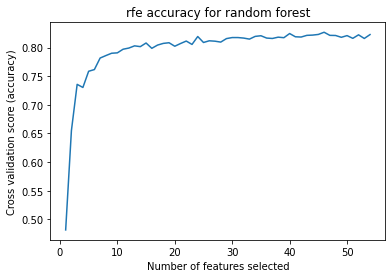

In [122]:
rfe, selected_features1 = feat_select(rf,X_var_selection6, y_var_selection2)
plot_results(rfe,'random forest')

Optimal number of features : 16


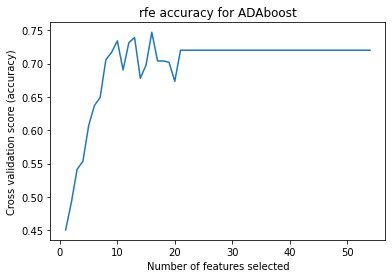

In [123]:
rfe, selected_features2 = feat_select(ada,X_var_selection6, y_var_selection2)
plot_results(rfe,'ADAboost')

Optimal number of features : 32


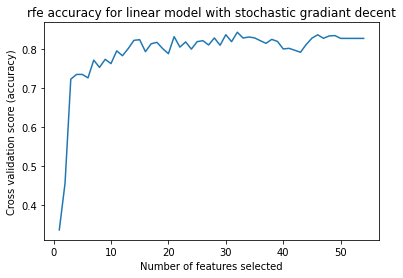

In [124]:
rfe, selected_features3 = feat_select(sgd,X_var_selection6, y_var_selection2)
plot_results(rfe,'linear model with stochastic gradiant decent')

Optimal number of features : 33


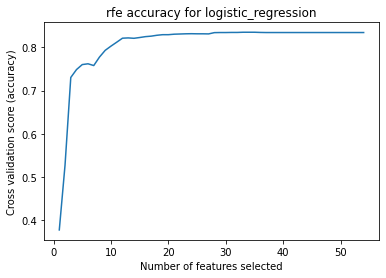

In [125]:
rfe, selected_features4= feat_select(lrs,X_var_selection6, y_var_selection2)
plot_results(rfe,'logistic_regression')

Optimal number of features : 43


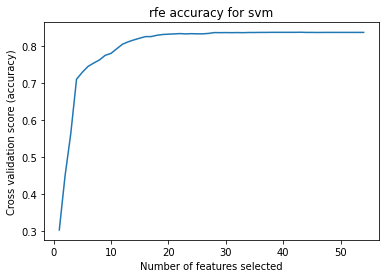

In [126]:
rfe, selected_features5 = feat_select(svm,X_var_selection6, y_var_selection2)
plot_results(rfe,'svm')

Optimal number of features : 42


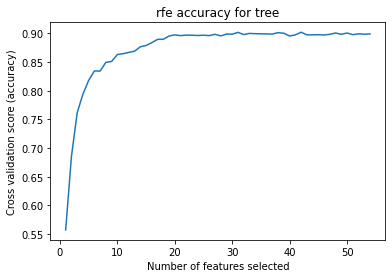

In [127]:
rfe, selected_features6 = feat_select(tree_class,X_var_selection6, y_var_selection2)
plot_results(rfe,'tree')


model = ExtraTreesClassifier()
model.fit(X_var_selection3,y_var_selection2)
feat_importances = pd.Series(model.feature_importances_, index=X_var_selection3.columns)
feat_importances.nlargest(18).plot(kind='barh')
plt.show()

feat_importances.nlargest(18)

model = ExtraTreesClassifier()
rf.fit(X_var_selection3,y_var_selection2)
feat_importances = pd.Series(rf.feature_importances_, index=X_var_selection3.columns)
feat_importances.nlargest(18).plot(kind='barh')
plt.show()


import matplotlib.pyplot as plt
lgbm = HistGradientBoostingClassifier(random_state= 7, categorical_features= [44,45,46,48,49,54])
lgbm_fitted =lgbm.fit(X_var_selection3,y_var_selection2)
result = permutation_importance(lgbm_fitted, X_var_selection3, y_var_selection2, n_repeats= 5, random_state= 1)
feat_importances = pd.Series(result.importances_mean, index=X_var_selection3.columns)
feat_importances.nlargest(18).plot(kind='barh')
plt.title('lightGBM model feature importance')
plt.show()

In [128]:
from collections import Counter
d = [selected_features1,selected_features2, selected_features3, selected_features4, selected_features5, selected_features6]
counter = Counter(x for sublist in d for x in sublist)
sorted_dict = {}
sorted_keys = sorted(counter, key=counter.get, reverse= True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = counter[w]
# We will use the predictors that were used in 4 mmodels and above
print(sorted_dict) # {1: 1, 3: 
selected_feats_final = [k for k, v in counter.items() if v >= 5]
#unique, counts = np.unique(d, return_counts=True)

#dict(zip(unique, counts))

{'serving_size': 6, '1004': 6, '1005': 6, '1008': 6, '1079': 6, '1086': 6, '1087': 6, '1162': 6, '1258': 6, '2000': 6, 'brandcol_2': 6, 'brandcol_7': 6, '1003': 5, '1090': 5, '1092': 5, '1095': 5, '1104': 5, '1235': 5, '1257': 5, '1292': 5, '1293': 5, 'brandcol_9': 5, 'brandcol_11': 5, 'brandcol_12': 5, 'brandcol_15': 5, 'brandcol_29': 5, 'servingcol_5': 5, 'servingcol_6': 5, 'servingcol_8': 5, 'servingcol_10': 5, '1089': 4, '1093': 4, '1098': 4, '1101': 4, '1175': 4, 'servingcol_9': 4, '1091': 3, '1166': 3, '1167': 3, '1253': 3, '1056': 2, '1084': 2, '1165': 2, '1177': 2, '1072': 1, '1082': 1, '1103': 1, '1109': 1, '1158': 1, '1185': 1}


In [129]:
selected_feats_final = np.array(selected_feats_final, dtype="str")
len(selected_feats_final)

30

In [130]:
X_var_selection4.loc[:,selected_feats_final]

,serving_size,1003,1004,1005,1008,1079,1086,1087,1090,1092,...,brandcol_7,brandcol_9,brandcol_11,brandcol_12,brandcol_15,brandcol_29,servingcol_5,servingcol_6,servingcol_8,servingcol_10
16113,28.0,7.14,28.57,60.71,500.0,3.6,0.0,71.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
8805,28.0,7.14,21.43,64.29,464.0,7.1,0.0,143.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
22135,41.0,0.00,0.00,82.93,341.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
25559,25.0,4.00,20.00,72.00,480.0,4.0,0.0,0.0,0.0,140.0,...,False,False,False,False,True,False,False,False,False,False
21079,40.0,5.00,42.50,50.00,525.0,12.5,0.0,50.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,30.0,3.33,13.33,70.00,433.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
10112,30.0,20.00,53.33,16.67,600.0,10.0,0.0,267.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2664,28.0,7.14,46.43,35.71,607.0,7.1,0.0,143.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
24438,31.0,6.45,29.03,61.29,516.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False


In [134]:
selected_feats_final

array(['serving_size', '1003', '1004', '1005', '1008', '1079', '1086',
       '1087', '1090', '1092', '1095', '1104', '1162', '1235', '1257',
       '1258', '1292', '1293', '2000', 'brandcol_2', 'brandcol_7',
       'brandcol_9', 'brandcol_11', 'brandcol_12', 'brandcol_15',
       'brandcol_29', 'servingcol_5', 'servingcol_6', 'servingcol_8',
       'servingcol_10'], dtype='<U13')

# model selection and tuning

In [132]:
X_mod_slct2 = X_mod_slct.copy()
X_mod_slct2 = X_mod_slct2.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in X_mod_slct2['brand']],
                     servings = ['other_serving' if item not in unique_serv_list else item for item in X_mod_slct2['servings']])
hashed_brand = encoder30.fit_transform(X_mod_slct2.brand)
hashed_serv =  encoder15.fit_transform(X_mod_slct2.servings)

hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')
hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')

# adding same index to prevent NAN's
hashed_serv.index = X_mod_slct2.index
hashed_brand.index = X_mod_slct2.index
X_mod_slct2 = pd.concat([X_mod_slct2,hashed_serv], axis = 1)
X_mod_slct2 = pd.concat([X_mod_slct2,hashed_brand], axis = 1)
X_mod_slct2 = X_mod_slct2.drop(['brand',"servings","category", "Unnamed: 0",'idx'], axis = 1)

cl = X_mod_slct2.columns.get_loc('2033') + 1
X_mod_slct2.iloc[ :,:cl] = X_mod_slct2.iloc[ :,:cl].astype('float64')
X_mod_slct2.iloc[ :,cl:] = X_mod_slct2.iloc[ :,cl:].astype('bool')
X_mod_slct2 =  X_mod_slct2.loc[:,selected_feats_final]

# droping the zero var columns 
vt = VarianceThreshold()
_ = vt.fit(X_mod_slct2)
mask = vt.get_support()
X_mod_slct3 = X_mod_slct2.loc[:, mask]

# determine categorical and numerical features that's left
numerical_ix = X_mod_slct3.select_dtypes(include=['float64']).columns
categorical_ix = X_mod_slct3.select_dtypes(include=[ 'bool']).columns

# transforming with min max
t = [ ('scale', MinMaxScaler(),numerical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')
X_trans = ct.fit_transform(X_mod_slct3)  
X_mod_slct4 = pd.DataFrame(X_trans, index=X_mod_slct3.index, columns=X_mod_slct3.columns)

# define pipeline
over = SMOTE(sampling_strategy='all')
under = RandomUnderSampler(sampling_strategy='all')
steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_mod_slct5, y_mod_slct2 = pipeline.fit_resample(X_mod_slct4, y_mod_slct)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# create models
ada = AdaBoostClassifier(random_state= 1)
sgd = SGDClassifier(random_state = 1)
tree_class = ExtraTreesClassifier(random_state= 1, criterion ='entropy')
lrs = LogisticRegression(random_state= 1, multi_class='ovr')
svm = LinearSVC(random_state = 1)
mnb = MultinomialNB()

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier'] = [rf]

param2 = {}
param2['classifier'] = [ada]

param3 = {}
param3['classifier'] = [tree_class]

param4 = {}
param4['classifier'] = [mnb]

param5 = {}
param5['classifier'] = [svm]


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
pipeline = Pipeline([('classifier', rf)])
params = [param1, param2, param3, param4, param5]
# Train the grid search model
gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='accuracy')
gs_results = gs.fit(X_mod_slct5, y_mod_slct2)

# Best performing model and its corresponding hyperparameters
print(gs.best_params_)
print(gs.best_score_)


{'classifier': ExtraTreesClassifier(criterion='entropy', random_state=1)}
0.8815670289855072


In [ ]:
rs = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='accuracy').fit(X_mod_slct5, y_mod_slct2)


/home/dovikde/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
rs.best_score_

0.8822463768115942

# model Tuning

In [ ]:
X_mod_tune2 = X_mod_tune.copy()
X_mod_tune2 = X_mod_tune2.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in X_mod_tune2['brand']],
                     servings = ['other_serving' if item not in unique_serv_list else item for item in X_mod_tune2['servings']])
hashed_brand = encoder30.fit_transform(X_mod_tune2.brand)
hashed_serv =  encoder15.fit_transform(X_mod_tune2.servings)

hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')c
hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')

# adding same index to prevent NAN's
hashed_serv.index = X_mod_tune2.index
hashed_brand.index = X_mod_tune2.index
X_mod_tune2 = pd.concat([X_mod_tune2,hashed_serv], axis = 1)
X_mod_tune2 = pd.concat([X_mod_tune2,hashed_brand], axis = 1)
X_mod_tune2 = X_mod_tune2.drop(['brand',"servings","category", "Unnamed: 0",'idx'], axis = 1)

cl = X_mod_tune2.columns.get_loc('2033') + 1
X_mod_tune2.iloc[ :,:cl] = X_mod_tune2.iloc[ :,:cl].astype('float64')
X_mod_tune2.iloc[ :,cl:] = X_mod_tune2.iloc[ :,cl:].astype('bool')
X_mod_tune2 =  X_mod_tune2.loc[:,selected_feats_final]

# droping the zero var columns 
vt = VarianceThreshold()
_ = vt.fit(X_mod_tune2)
mask = vt.get_support()
X_mod_tune2 = X_mod_tune2.loc[:, mask]

# determine categorical and numerical features that's left
numerical_ix = X_mod_tune2.select_dtypes(include=['float64']).columns
categorical_ix = X_mod_tune2.select_dtypes(include=[ 'bool']).columns

# transforming with min max
t = [ ('scale', MinMaxScaler(),numerical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')
X_trans = ct.fit_transform(X_mod_tune2)  
X_mod_tune2 = pd.DataFrame(X_trans, index=X_mod_tune2.index, columns=X_mod_tune2.columns)

# define pipeline
over = SMOTE(sampling_strategy='all')
under = RandomUnderSampler(sampling_strategy='all')
steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_mod_tune2, y_mod_tune2 = pipeline.fit_resample(X_mod_tune2, y_mod_tune)

In [ ]:
params = [{'n_estimators': [50,100,150,250, 500],
    'max_depth': [None, 5, 10, 25],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,5,10],
    'max_leaf_nodes':[5,10,25,None]
    }]

In [ ]:
pipeline = Pipeline([('tree',  ExtraTreesClassifier(random_state= 1, criterion ='entropy'))])
grid = GridSearchCV(ExtraTreesClassifier(random_state= 1, criterion ='entropy'), params, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_mod_tune2, y_mod_tune2)

GridSearchCV(cv=3,
             estimator=ExtraTreesClassifier(criterion='entropy',
                                            random_state=1),
             n_jobs=-1,
             param_grid=[{'max_depth': [None, 5, 10, 25],
                          'max_leaf_nodes': [5, 10, 25, None],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [50, 100, 150, 250, 500]}],
             scoring='accuracy')

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}
0.8908514492753623


And thats the model we will choose!

In [40]:
selected_feats_final = np.array(['serving_size', '1003', '1004', '1005', '1008', '1079', '1086',
       '1087', '1090', '1092', '1095', '1104', '1162', '1235', '1257',
       '1258', '1292', '1293', '2000', 'brandcol_2', 'brandcol_7',
       'brandcol_9', 'brandcol_11', 'brandcol_12', 'brandcol_15',
       'brandcol_29', 'servingcol_5', 'servingcol_6', 'servingcol_8',
       'servingcol_10'])

In [46]:
def concluded_data(copied_data, y_data):
    new_data = copied_data.copy()
    new_data = new_data.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in new_data['brand']],
                        servings = ['other_serving' if item not in unique_serv_list else item for item in new_data['servings']])
    hashed_brand = encoder30.fit_transform(new_data.brand)
    hashed_serv =  encoder15.fit_transform(new_data.servings)

    hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')
    hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')

    # adding same index to prevent NAN's
    hashed_serv.index = new_data.index
    hashed_brand.index = new_data.index
    new_data = pd.concat([new_data,hashed_serv], axis = 1)
    new_data = pd.concat([new_data,hashed_brand], axis = 1)
    new_data = new_data.set_index('idx')
    new_data = new_data.drop(['brand',"servings","category", "Unnamed: 0"], axis = 1)

    cl = new_data.columns.get_loc('2033') + 1
    new_data.iloc[ :,:cl] = new_data.iloc[ :,:cl].astype('float64')
    new_data.iloc[ :,cl:] = new_data.iloc[ :,cl:].astype('bool')
    new_data =  new_data.loc[:,selected_feats_final]

    # droping the zero var columns 
    vt = VarianceThreshold()
    _ = vt.fit(new_data)
    mask = vt.get_support()
    new_data = new_data.loc[:, mask]

    # determine categorical and numerical features that's left
    numerical_ix = new_data.select_dtypes(include=['float64']).columns
    #categorical_ix = new_data.select_dtypes(include=[ 'bool']).columns

    # transforming with min max
    t = [ ('scale', MinMaxScaler(),numerical_ix)]
    ct = ColumnTransformer(transformers=t, remainder='passthrough')
    X_trans = ct.fit_transform(new_data)  
    new_data = pd.DataFrame(X_trans, index=new_data.index, columns=new_data.columns)

    # define pipeline
    over = SMOTE(sampling_strategy='all')
    under = RandomUnderSampler(sampling_strategy='all')
    steps = [('u', under),('o', over)]
    pipeline = Pipeline(steps=steps)

    # transform the dataset
    new_data, y2 = pipeline.fit_resample(new_data, y = y_data)
    return new_data, y2

In [47]:
main5 ,lable2 = concluded_data(main4, lable)

In [48]:
main5

,serving_size,1003,1004,1005,1008,1079,1086,1087,1090,1092,...,brandcol_7,brandcol_9,brandcol_11,brandcol_12,brandcol_15,brandcol_29,servingcol_5,servingcol_6,servingcol_8,servingcol_10
0,0.047470,0.0435,0.1957,0.5217,0.181270,0.000,0.0,0.001305,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.232974,0.0446,0.1607,0.3571,0.144645,0.009,0.0,0.001065,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.089156,0.0465,0.2326,0.5581,0.215577,0.023,0.0,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.282997,0.0368,0.1691,0.2647,0.126101,0.000,0.0,0.000660,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.235058,0.0265,0.1062,0.2920,0.102457,0.018,0.0,0.000795,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22075,0.057892,0.1429,0.3929,0.4286,0.248493,0.071,0.0,0.001065,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22076,0.057892,0.1429,0.3214,0.5357,0.248493,0.071,0.0,0.002145,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22077,0.062060,0.1333,0.6000,0.2333,0.293463,0.067,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22078,0.057892,0.1786,0.7143,0.1071,0.347705,0.107,0.0,0.001065,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
final_model = ExtraTreesClassifier(n_estimators = 250, 
min_samples_split = 5, 
random_state = 1,
min_samples_leaf = 1,
criterion = 'entropy', bootstrap= True)
#final_model.fit(main5, lable2)


In [71]:
scores = cross_val_score(final_model, main5, lable2, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: ' , np.mean(scores))

Mean accuracy:  0.9120320048309178


In [72]:
final_model.fit(main5, lable2)

ExtraTreesClassifier(bootstrap=True, criterion='entropy', min_samples_split=5,
                     n_estimators=250, random_state=1)

In [184]:
# doing the same for the test set

In [73]:
# return all the numbers in nutrient id
# nut_wide = nutrients.pivot(index="idx", columns="nutrient_id", values="amount")
nut_ids = ['idx']
for id in nutrients.nutrient_id:
    nut_ids.append(id)

nut_data = pd.DataFrame(columns = nut_ids)
nut_data

,idx,1002,1003,1004,1005,1007,1008,1009,1010,1011,...,2021,2022,2023,2024,2025,2026,2028,2029,2032,2033


In [74]:
food_test.shape
print(range(4).step)

1


#start_time = time.time()
appended_data = [nut_data]
for value in range(3525):
    # for every snack in the training sample get it's nutritional values
    indx = food_test['idx'][value]
    df2 = food_nutrients.query("idx == @indx").loc[:, 'nutrient_id':'amount'].set_index("nutrient_id").T
    df2['idx']= indx
    appended_data.append(df2)
    print(value)

appended_data = pd.concat(appended_data, axis=0)

#end_time = time.time()
#print('Execution time = %.6f seconds' % (end_time-start_time))

In [75]:
appended_data2 = pd.read_csv('/home/dovikde/Documents/Studies/Ds_applications/Final_ProjectTuchdov/data/all_nuts_test.csv')
# fill zero where there isn't any nutritional data
appended_data2 = appended_data2.fillna(0.0).reset_index(drop = True)


In [76]:
main_test = food_test.merge(appended_data2, on='idx', how='left')
#main

main_test.loc[:, "serving_size_unit"] = main.serving_size_unit.astype('category')

# make a list of unique brands in each category
# leave the brands that  only belong to one category
# list of categorys
cat_list = food_train.category.unique()


In [77]:
# get all the brands in each category
cat_brand_list = []
for cat in cat_list:
    brand_list = food_train.query('category == @cat').brand.unique()
    cat_brand_list.append(brand_list)


In [78]:
# get all the brands in other categories
other_brand_list = []
for cat in cat_list:
    brand_list = food_train.query('category != @cat').brand.unique()
    other_brand_list.append(brand_list)


In [79]:
# brands that only belong to one category
only_cat = []
for i in range(len(cat_brand_list)):
    mask = np.isin(cat_brand_list[i], other_brand_list[i], invert= True)
    unique_category_brands = cat_brand_list[i][mask]
    only_cat.append(unique_category_brands)
    
#main = main.assign(brand = ['chocolate brand' if a > 0 else 'neg' for a in df['a']])

In [80]:
main_test = main_test.assign(brand = ['chocolate_brand' if item in only_cat[0] else item for item in main_test['brand']])
main_test = main_test.assign(brand = ['cookies_biscuits_brand' if item in only_cat[1] else item for item in main_test['brand']])
main_test = main_test.assign(brand = ['cakes_cupcakes_snack_cakes_brand' if item in only_cat[2] else item for item in main_test['brand']])
main_test = main_test.assign(brand = ['candy_brand' if item in only_cat[3] else item for item in main_test['brand']])
main_test = main_test.assign(brand = ['chips_pretzels_snacks_brand' if item in only_cat[4] else item for item in main_test['brand']])
main_test = main_test.assign(brand = ['popcorn_peanuts_seeds_related_snacks_brand' if item in only_cat[5] else item for item in main_test['brand']])

In [81]:

main_test.loc[:, "servings"] = main_test.loc[:, "household_serving_fulltext"].str.strip().str.replace('[^a-zA-Z ]', "").str.replace('about', "").str.replace('per container', "").str.strip()
main_test.insert(7,"servings", main_test.pop('servings'))

/tmp/ipykernel_4752/2076572199.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  main_test.loc[:, "servings"] = main_test.loc[:, "household_serving_fulltext"].str.strip().str.replace('[^a-zA-Z ]', "").str.replace('about', "").str.replace('per container', "").str.strip()


In [82]:
# make a list of unique brands in each category
# leave the brands that  only belong to one category
# list of categorys
cat_list = food_train.category.unique()
cat_list
# get all the brands in each category
serv_brand_list = []
for cat in cat_list:
    brand_list = main2.query('category == @cat').servings.unique()
    serv_brand_list.append(brand_list)

# get all the brands in other categories
other_serv_list = []
for cat in cat_list:
    brand_list = main2.query('category != @cat').servings.unique()
    other_serv_list.append(brand_list)

# brands that only belong to one category
only_serv = []
for i in range(len(serv_brand_list)):
    mask = np.isin(serv_brand_list[i], other_serv_list[i], invert= True)
    unique_category_servings = serv_brand_list[i][mask]
    only_serv.append(unique_category_servings)
    
#main = main.assign(brand = ['chocolate brand' if a > 0 else 'neg' for a in df['a']])
main_test = main_test.assign(servings = ['chocolate_servings' if item in only_serv[0] else item for item in main_test['servings']])
main_test = main_test.assign(servings = ['cookies_biscuits_servings' if item in only_serv[1] else item for item in main_test['servings']])
main_test = main_test.assign(servings = ['cakes_cupcakes_snack_cakes_servings' if item in only_serv[2] else item for item in main_test['servings']])
main_test = main_test.assign(servings = ['candy_servings' if item in only_serv[3] else item for item in main_test['servings']])
main_test = main_test.assign(servings = ['chips_pretzels_snacks_servings' if item in only_serv[4] else item for item in main_test['servings']])
main_test = main_test.assign(servings = ['popcorn_peanuts_seeds_related_snacks_servings' if item in only_serv[5] else item for item in main_test['servings']])# doing the same thing I did with brands to servings


In [83]:
# let's try to stemm
stemmer = SnowballStemmer("english") #define stemming dict

main_test.loc[:,"servings"] = main_test.loc[:,"servings"].astype(str)
main_test.loc[:,"servings"]= main_test.loc[:,"servings"].apply(stemmer.stem)

There are only 8 observations that have ml in them, i will choosr to drop themb

In [84]:
# main4 = main3.query("serving_size_unit != 'ml'")
main_test = main_test.drop(['household_serving_fulltext',"serving_size_unit","ingredients","description"], axis = 1)
main_test.loc[:,'brand'] = main_test.loc[:,'brand'].astype('category')

In [85]:
main_test.to_csv('actual_main.csv')

In [86]:
main_test

,idx,brand,serving_size,servings,Unnamed: 0,1002,1003,1004,1005,1007,...,2021,2022,2023,2024,2025,2026,2028,2029,2032,2033
0,13,"csm bakery products na, inc.",39.0,grm,amount,0.0,2.56,11.54,64.10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15,chips_pretzels_snacks_brand,28.0,onz,amount,0.0,7.14,12.50,75.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16,cookies_biscuits_brand,28.0,cooki,amount,0.0,10.71,17.86,64.29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23,"safeway, inc.",28.0,chip,amount,0.0,7.14,25.00,64.29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40,"inventure foods, inc.",28.0,onz,amount,0.0,7.14,25.00,60.71,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,35215,mike-sell's potato chip co.,28.0,onz,amount,0.0,7.14,25.00,60.71,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3521,35241,true north,28.0,onz,amount,0.0,17.86,42.86,32.14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3522,35255,first street,16.0,piec,amount,0.0,0.00,0.00,100.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3523,35258,lindt & sprungli (schweiz) ag,28.0,egg,amount,0.0,3.57,46.43,42.86,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will apply the transform on the test set

In [87]:
def concluded_test(copied_data):
    new_data = copied_data.copy()
    #new_data = new_data.assign(brand = ['other_brand' if item not in unique_brand_list else item for item in new_data['brand']],
    #                    servings = ['other_serving' if item not in unique_serv_list else item for item in new_data['servings']])
    hashed_brand = encoder30.fit_transform(new_data.brand)
    hashed_serv =  encoder15.fit_transform(new_data.servings)

    hashed_brand = pd.DataFrame(hashed_brand).add_prefix('brand')
    hashed_serv = pd.DataFrame(hashed_serv).add_prefix('serving')

    # adding same index to prevent NAN's
    hashed_serv.index = new_data.index
    hashed_brand.index = new_data.index
    new_data = pd.concat([new_data,hashed_serv], axis = 1)
    new_data = pd.concat([new_data,hashed_brand], axis = 1)
    new_data = new_data.set_index('idx')
    new_data = new_data.drop(['brand',"servings", "Unnamed: 0"], axis = 1)

    cl = new_data.columns.get_loc('2033') + 1
    new_data.iloc[ :,:cl] = new_data.iloc[ :,:cl].astype('float64')
    new_data.iloc[ :,cl:] = new_data.iloc[ :,cl:].astype('bool')
    new_data =  new_data.loc[:,selected_feats_final]

    # droping the zero var columns 
    vt = VarianceThreshold()
    _ = vt.fit(new_data)
    mask = vt.get_support()
    new_data = new_data.loc[:, mask]

    # determine categorical and numerical features that's left
    numerical_ix = new_data.select_dtypes(include=['float64']).columns
    #categorical_ix = new_data.select_dtypes(include=[ 'bool']).columns

    # transforming with min max
    t = [ ('scale', MinMaxScaler(),numerical_ix)]
    ct = ColumnTransformer(transformers=t, remainder='passthrough')
    X_trans = ct.fit_transform(new_data)  
    new_data = pd.DataFrame(X_trans, index=new_data.index, columns=new_data.columns)
    return new_data

In [88]:
main_test2 = concluded_test(main_test)

In [89]:
pred = final_model.predict(main_test2)

In [91]:
results = pd.Series(list(lb.inverse_transform(pred)))
test_idx = food_test.idx
d = {'idx': test_idx, 'pred_cat': results}
df = pd.DataFrame(data=d)
df.reset_index(drop = True)

,idx,pred_cat
0,13,popcorn_peanuts_seeds_related_snacks
1,15,chips_pretzels_snacks
2,16,cookies_biscuits
3,23,chips_pretzels_snacks
4,40,chips_pretzels_snacks
...,...,...
3520,35215,chips_pretzels_snacks
3521,35241,popcorn_peanuts_seeds_related_snacks
3522,35255,cakes_cupcakes_snack_cakes
3523,35258,cakes_cupcakes_snack_cakes


In [92]:
df.to_csv("./model02b.csv")  

In [ ]:
X_dtrain, X_dtest, y_dtrain, y_dtest = train_test_split(main4, lable, stratify = lable )

In [ ]:
X_tr, y_tr = concluded_data(X_dtrain, y_dtrain)

In [ ]:
X_dtest = X_dtest.drop(['category'])

In [ ]:
X_ts = concluded_test(X_dtest.drop('category', axis = 1))

In [ ]:
final_model = ExtraTreesClassifier(n_estimators = 250, 
min_samples_split = 5, 
random_state = 1,
min_samples_leaf = 1,
criterion = 'entropy')
#final_model.fit(main5, lable2)

In [ ]:
final_model.fit(X_tr, y_tr)

ExtraTreesClassifier(criterion='entropy', min_samples_split=5, n_estimators=250,
                     random_state=1)

In [ ]:
X_dtest.to_csv('main_prop.csv')

In [ ]:
from sklearn.metrics import accuracy_score
pr= final_model.predict(X_ts)
accuracy_score(pr, y_dtest)

0.8645754598135551

In [ ]:
test_idx.reset_index(drop = True)

0       21900
1        8190
2       14002
3         565
4       32860
        ...  
7933    28418
7934    29252
7935    16265
7936    10107
7937    21191
Name: idx, Length: 7938, dtype: int64

In [ ]:
df2.to_csv('prop1.csv')

In [ ]:

results = pd.Series(list(lb.inverse_transform(pr)))
test_idx = X_dtest.idx.reset_index(drop = True)
d = {'idx': test_idx, 'pred_cat': results}
df2 = pd.DataFrame(data=d)
df2

,idx,pred_cat
0,21900,cookies_biscuits
1,8190,chocolate
2,14002,cookies_biscuits
3,565,chocolate
4,32860,cakes_cupcakes_snack_cakes
...,...,...
7933,28418,cookies_biscuits
7934,29252,cookies_biscuits
7935,16265,cakes_cupcakes_snack_cakes
7936,10107,candy
